# Regression Models for Power Outage Impact Prediction

This notebook builds and evaluates regression models to predict continuous outcomes related to power outages.

## Objectives
1. Predict **outage duration** (hours)
2. Predict **customers affected** (count)
3. Predict **demand loss** (MW)

## Models Implemented
- Linear Regression
- Ridge Regression (L2 regularization)
- Lasso Regression (L1 regularization)
- Random Forest Regressor
- Gradient Boosting Regressor

## Research Question Addressed
> Can we predict power outage severity (duration, customers affected) based on wildfire characteristics?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
pd.set_option('display.max_columns', 50)

# Path configuration
FEATURES_PATH = '../data/features/'
OUTPUTS_PATH = '../outputs/'

In [3]:
# Load the feature-engineered dataset
df = pd.read_csv(FEATURES_PATH + 'california_outages_with_fire_features.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nTarget variables (continuous):")
print(f"  - OUTAGE.DURATION: {df['OUTAGE.DURATION'].describe()[['count', 'mean', 'std', 'min', 'max']].to_dict()}")
print(f"  - CUSTOMERS.AFFECTED: {df['CUSTOMERS.AFFECTED'].describe()[['count', 'mean', 'std', 'min', 'max']].to_dict()}")
print(f"  - DEMAND.LOSS.MW: {df['DEMAND.LOSS.MW'].describe()[['count', 'mean', 'std', 'min', 'max']].to_dict()}")

Dataset shape: (210, 35)

Target variables (continuous):
  - OUTAGE.DURATION: {'count': 198.0, 'mean': 1666.3383838383838, 'std': 4785.495500936519, 'min': 0.0, 'max': 49427.0}
  - CUSTOMERS.AFFECTED: {'count': 127.0, 'mean': 201365.71653543308, 'std': 408357.5348725731, 'min': 0.0, 'max': 2606931.0}
  - DEMAND.LOSS.MW: {'count': 158.0, 'mean': 667.5949367088608, 'std': 3512.537803659885, 'min': 0.0, 'max': 41788.0}


---
## Target Variable Analysis

Examine distributions of target variables to determine if transformations are needed.

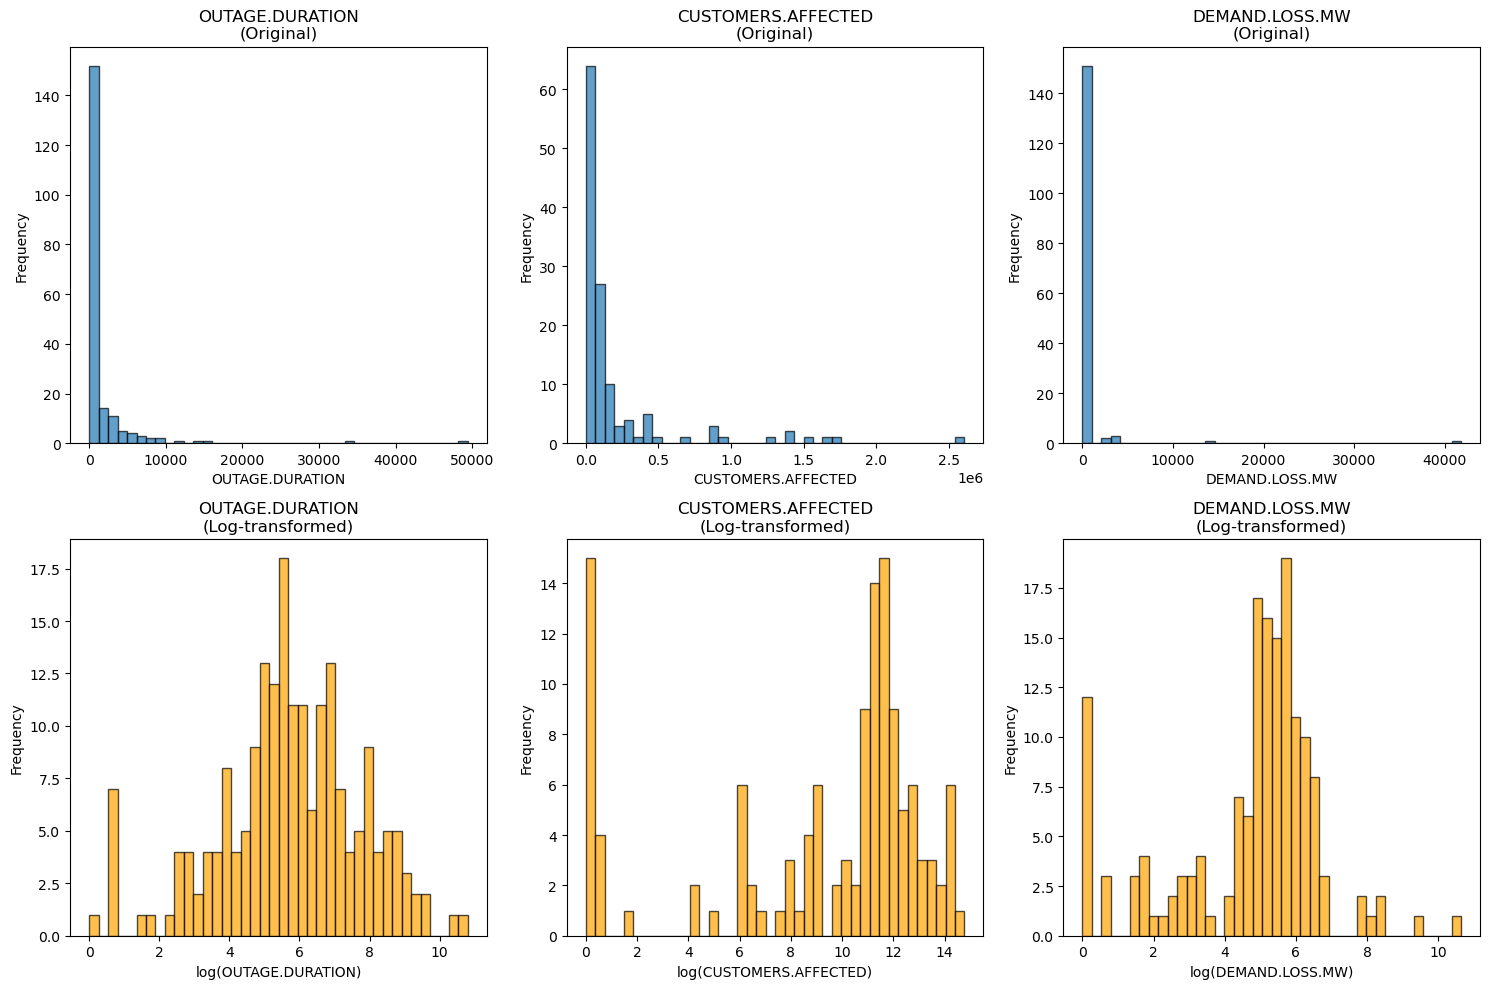

Target variables are heavily right-skewed. Log transformation recommended.


In [4]:
# Plot distributions of target variables
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

targets = ['OUTAGE.DURATION', 'CUSTOMERS.AFFECTED', 'DEMAND.LOSS.MW']

for i, target in enumerate(targets):
    # Original distribution
    axes[0, i].hist(df[target].dropna(), bins=40, edgecolor='black', alpha=0.7)
    axes[0, i].set_title(f'{target}\n(Original)')
    axes[0, i].set_xlabel(target)
    axes[0, i].set_ylabel('Frequency')
    
    # Log-transformed distribution
    log_data = np.log1p(df[target].dropna())
    axes[1, i].hist(log_data, bins=40, edgecolor='black', alpha=0.7, color='orange')
    axes[1, i].set_title(f'{target}\n(Log-transformed)')
    axes[1, i].set_xlabel(f'log({target})')
    axes[1, i].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig(OUTPUTS_PATH + 'figures/target_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Target variables are heavily right-skewed. Log transformation recommended.")

---
## Data Preparation

In [5]:
# Define feature groups (same as classification)
temporal_features = ['outage_month', 'outage_dayofweek', 'outage_quarter', 
                     'is_wildfire_season', 'is_weekend']

fire_features = ['daily_fire_count', 'daily_acres_burned', 'avg_fire_size', 'max_fire_size',
                 'large_fire_count', 'large_fire_acres', 'satellite_detections',
                 'total_frp', 'avg_frp', 'max_frp', 'avg_confidence',
                 'fires_7day', 'fires_30day', 'acres_7day', 'acres_30day',
                 'has_active_fire', 'is_high_fire_activity']

categorical_features = ['season', 'CAUSE.CATEGORY']

# Filter to existing columns
temporal_features = [col for col in temporal_features if col in df.columns]
fire_features = [col for col in fire_features if col in df.columns]
categorical_features = [col for col in categorical_features if col in df.columns]

all_features = temporal_features + fire_features + categorical_features
print(f"Total features: {len(all_features)}")

Total features: 24


In [6]:
def prepare_regression_data(df, target_col, feature_cols, categorical_cols, log_transform=True):
    """
    Prepare features and target for regression.
    Optionally applies log transformation to target.
    """
    # Create copy
    data = df.copy()
    
    # Remove rows where target is missing or zero (for log transform)
    data = data[data[target_col].notna()]
    if log_transform:
        data = data[data[target_col] > 0]
    
    # Separate features
    X = data[feature_cols].copy()
    y = data[target_col].copy()
    
    # Apply log transformation to target
    if log_transform:
        y = np.log1p(y)
    
    # Handle missing values in numeric columns
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        imputer = SimpleImputer(strategy='median')
        X[numeric_cols] = imputer.fit_transform(X[numeric_cols])
    
    # One-hot encode categorical columns
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    
    return X, y

# Prepare data for outage duration prediction
X, y = prepare_regression_data(df, 'OUTAGE.DURATION', all_features, categorical_features, log_transform=True)

print(f"Feature matrix shape: {X.shape}")
print(f"Target (log-transformed duration) stats:")
print(f"  Mean: {y.mean():.3f}")
print(f"  Std: {y.std():.3f}")
print(f"  Range: [{y.min():.3f}, {y.max():.3f}]")

Feature matrix shape: (197, 31)
Target (log-transformed duration) stats:
  Mean: 5.749
  Std: 1.999
  Range: [0.693, 10.808]


In [7]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set: 157 samples
Test set: 40 samples


---
## Model Training and Evaluation

In [8]:
def evaluate_regressor(model, X_train, X_test, y_train, y_test, model_name, log_transformed=True):
    """
    Train and evaluate a regression model.
    Returns metrics in both log and original scale.
    """
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metrics in log scale
    mae_log = mean_absolute_error(y_test, y_pred)
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Convert back to original scale for interpretable metrics
    if log_transformed:
        y_test_orig = np.expm1(y_test)
        y_pred_orig = np.expm1(y_pred)
        mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)
        rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    else:
        mae_orig = mae_log
        rmse_orig = rmse_log
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    metrics = {
        'Model': model_name,
        'MAE (log)': mae_log,
        'RMSE (log)': rmse_log,
        'R2': r2,
        'MAE (original)': mae_orig,
        'RMSE (original)': rmse_orig,
        'CV R2 (mean)': cv_scores.mean(),
        'CV R2 (std)': cv_scores.std()
    }
    
    return metrics, y_pred, model

In [9]:
# 1. Linear Regression
print("=" * 80)
print("LINEAR REGRESSION")
print("=" * 80)

lr_model = LinearRegression()
lr_metrics, lr_pred, lr_trained = evaluate_regressor(
    lr_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Linear Regression'
)

print(f"\nTest Set Performance:")
for metric, value in lr_metrics.items():
    if metric != 'Model':
        print(f"  {metric}: {value:.4f}")

LINEAR REGRESSION

Test Set Performance:
  MAE (log): 1.8555
  RMSE (log): 2.2196
  R2: -0.0600
  MAE (original): 1746.9638
  RMSE (original): 3235.6412
  CV R2 (mean): -0.2204
  CV R2 (std): 0.3233


In [10]:
# 2. Ridge Regression
print("=" * 80)
print("RIDGE REGRESSION (L2 Regularization)")
print("=" * 80)

ridge_model = Ridge(alpha=1.0)
ridge_metrics, ridge_pred, ridge_trained = evaluate_regressor(
    ridge_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Ridge Regression'
)

print(f"\nTest Set Performance:")
for metric, value in ridge_metrics.items():
    if metric != 'Model':
        print(f"  {metric}: {value:.4f}")

RIDGE REGRESSION (L2 Regularization)

Test Set Performance:
  MAE (log): 1.8237
  RMSE (log): 2.1790
  R2: -0.0216
  MAE (original): 1656.5889
  RMSE (original): 3052.3009
  CV R2 (mean): 0.0400
  CV R2 (std): 0.0726


In [11]:
# 3. Lasso Regression
print("=" * 80)
print("LASSO REGRESSION (L1 Regularization)")
print("=" * 80)

lasso_model = Lasso(alpha=0.1)
lasso_metrics, lasso_pred, lasso_trained = evaluate_regressor(
    lasso_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Lasso Regression'
)

print(f"\nTest Set Performance:")
for metric, value in lasso_metrics.items():
    if metric != 'Model':
        print(f"  {metric}: {value:.4f}")

# Show Lasso feature selection (non-zero coefficients)
lasso_coef = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lasso_trained.coef_
})
non_zero = lasso_coef[lasso_coef['coefficient'] != 0].sort_values('coefficient', key=abs, ascending=False)
print(f"\nLasso selected {len(non_zero)} features out of {len(X.columns)}")
print("Top 10 features by coefficient magnitude:")
print(non_zero.head(10).to_string(index=False))

LASSO REGRESSION (L1 Regularization)

Test Set Performance:
  MAE (log): 1.7330
  RMSE (log): 2.1125
  R2: 0.0398
  MAE (original): 1508.7866
  RMSE (original): 3001.7359
  CV R2 (mean): 0.1439
  CV R2 (std): 0.1342

Lasso selected 13 features out of 31
Top 10 features by coefficient magnitude:
                                     feature  coefficient
                    CAUSE.CATEGORY_islanding    -0.518779
           CAUSE.CATEGORY_intentional attack    -0.304274
               CAUSE.CATEGORY_severe weather     0.281658
                             has_active_fire    -0.264262
                               season_Winter     0.256113
        CAUSE.CATEGORY_fuel supply emergency     0.221971
                            outage_dayofweek     0.175271
CAUSE.CATEGORY_system operability disruption    -0.146846
                                     max_frp     0.119703
                                  is_weekend     0.117857


In [12]:
# 4. Random Forest Regressor
print("=" * 80)
print("RANDOM FOREST REGRESSOR")
print("=" * 80)

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_metrics, rf_pred, rf_trained = evaluate_regressor(
    rf_model, X_train, X_test, y_train, y_test, 'Random Forest'
)

print(f"\nTest Set Performance:")
for metric, value in rf_metrics.items():
    if metric != 'Model':
        print(f"  {metric}: {value:.4f}")

RANDOM FOREST REGRESSOR

Test Set Performance:
  MAE (log): 1.5616
  RMSE (log): 2.0191
  R2: 0.1228
  MAE (original): 1391.8393
  RMSE (original): 2846.0668
  CV R2 (mean): -0.0084
  CV R2 (std): 0.1368


Top 15 Most Important Features for Duration Prediction:
                          feature  importance
         CAUSE.CATEGORY_islanding    0.088728
    CAUSE.CATEGORY_severe weather    0.087998
                       acres_7day    0.067153
                   avg_confidence    0.065387
               daily_acres_burned    0.065252
                 daily_fire_count    0.059714
                      fires_30day    0.055992
                    avg_fire_size    0.055423
                       fires_7day    0.054306
                      acres_30day    0.051287
                     outage_month    0.042066
                    max_fire_size    0.038190
                          avg_frp    0.037407
CAUSE.CATEGORY_intentional attack    0.033270
             satellite_detections    0.030633


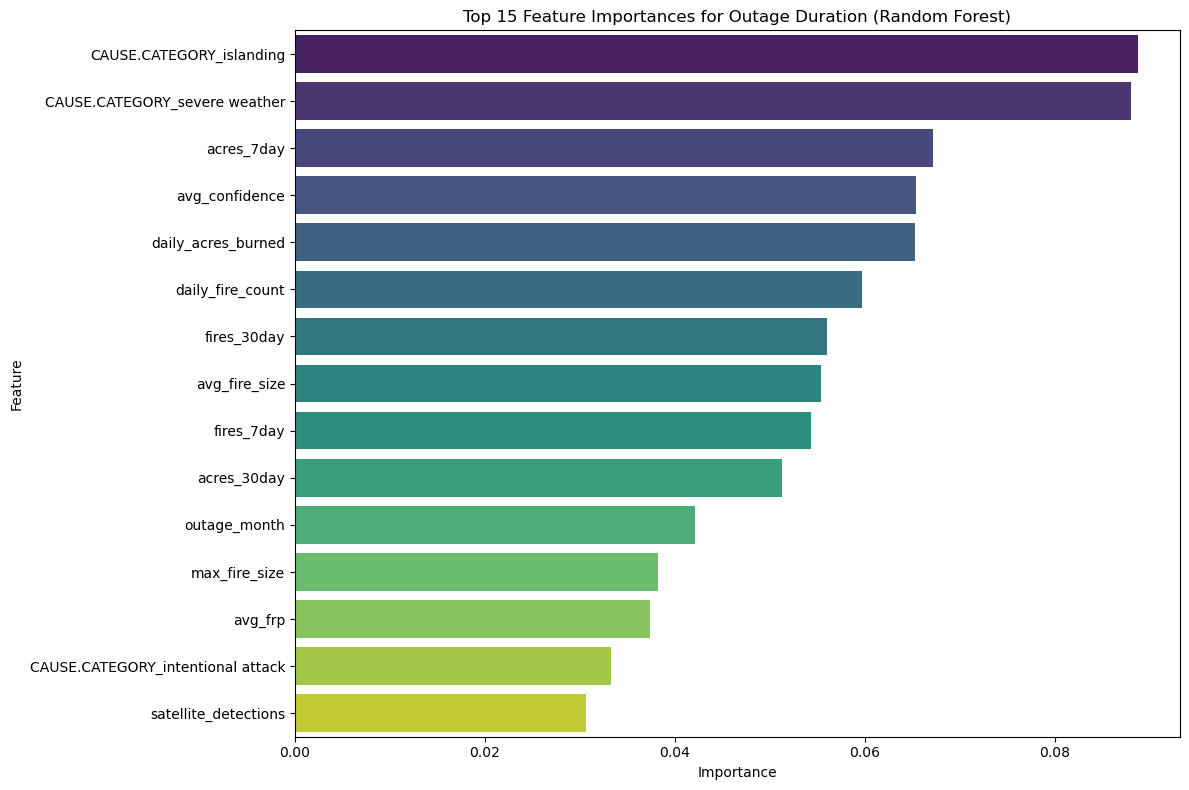

In [13]:
# Feature Importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_trained.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features for Duration Prediction:")
print(feature_importance.head(15).to_string(index=False))

# Plot
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
plt.title('Top 15 Feature Importances for Outage Duration (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig(OUTPUTS_PATH + 'figures/feature_importance_regression.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
# 5. Gradient Boosting Regressor
print("=" * 80)
print("GRADIENT BOOSTING REGRESSOR")
print("=" * 80)

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

gb_metrics, gb_pred, gb_trained = evaluate_regressor(
    gb_model, X_train, X_test, y_train, y_test, 'Gradient Boosting'
)

print(f"\nTest Set Performance:")
for metric, value in gb_metrics.items():
    if metric != 'Model':
        print(f"  {metric}: {value:.4f}")

GRADIENT BOOSTING REGRESSOR

Test Set Performance:
  MAE (log): 1.8827
  RMSE (log): 2.3141
  R2: -0.1522
  MAE (original): 1754.0286
  RMSE (original): 3080.6887
  CV R2 (mean): -0.2247
  CV R2 (std): 0.1476


---
## Model Comparison

In [15]:
# Compile all metrics
all_metrics = pd.DataFrame([lr_metrics, ridge_metrics, lasso_metrics, rf_metrics, gb_metrics])

print("=" * 80)
print("MODEL COMPARISON - OUTAGE DURATION PREDICTION")
print("=" * 80)
print(all_metrics.round(4).to_string(index=False))

# Highlight best model
best_model_idx = all_metrics['R2'].idxmax()
best_model = all_metrics.loc[best_model_idx, 'Model']
print(f"\nBest Model (by R2): {best_model}")

MODEL COMPARISON - OUTAGE DURATION PREDICTION
            Model  MAE (log)  RMSE (log)      R2  MAE (original)  RMSE (original)  CV R2 (mean)  CV R2 (std)
Linear Regression     1.8555      2.2196 -0.0600       1746.9638        3235.6412       -0.2204       0.3233
 Ridge Regression     1.8237      2.1790 -0.0216       1656.5889        3052.3009        0.0400       0.0726
 Lasso Regression     1.7330      2.1125  0.0398       1508.7866        3001.7359        0.1439       0.1342
    Random Forest     1.5616      2.0191  0.1228       1391.8393        2846.0668       -0.0084       0.1368
Gradient Boosting     1.8827      2.3141 -0.1522       1754.0286        3080.6887       -0.2247       0.1476

Best Model (by R2): Random Forest


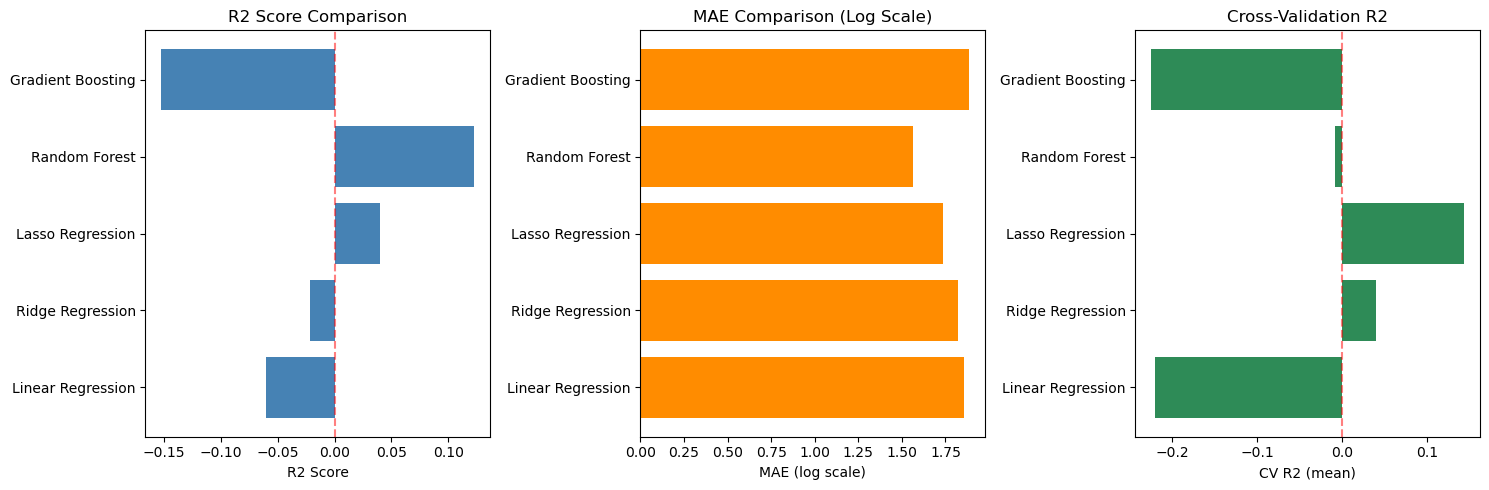

In [16]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# R2 comparison
axes[0].barh(all_metrics['Model'], all_metrics['R2'], color='steelblue')
axes[0].set_xlabel('R2 Score')
axes[0].set_title('R2 Score Comparison')
axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.5)

# MAE comparison (log scale)
axes[1].barh(all_metrics['Model'], all_metrics['MAE (log)'], color='darkorange')
axes[1].set_xlabel('MAE (log scale)')
axes[1].set_title('MAE Comparison (Log Scale)')

# CV R2 comparison
axes[2].barh(all_metrics['Model'], all_metrics['CV R2 (mean)'], color='seagreen')
axes[2].set_xlabel('CV R2 (mean)')
axes[2].set_title('Cross-Validation R2')
axes[2].axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(OUTPUTS_PATH + 'figures/regression_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

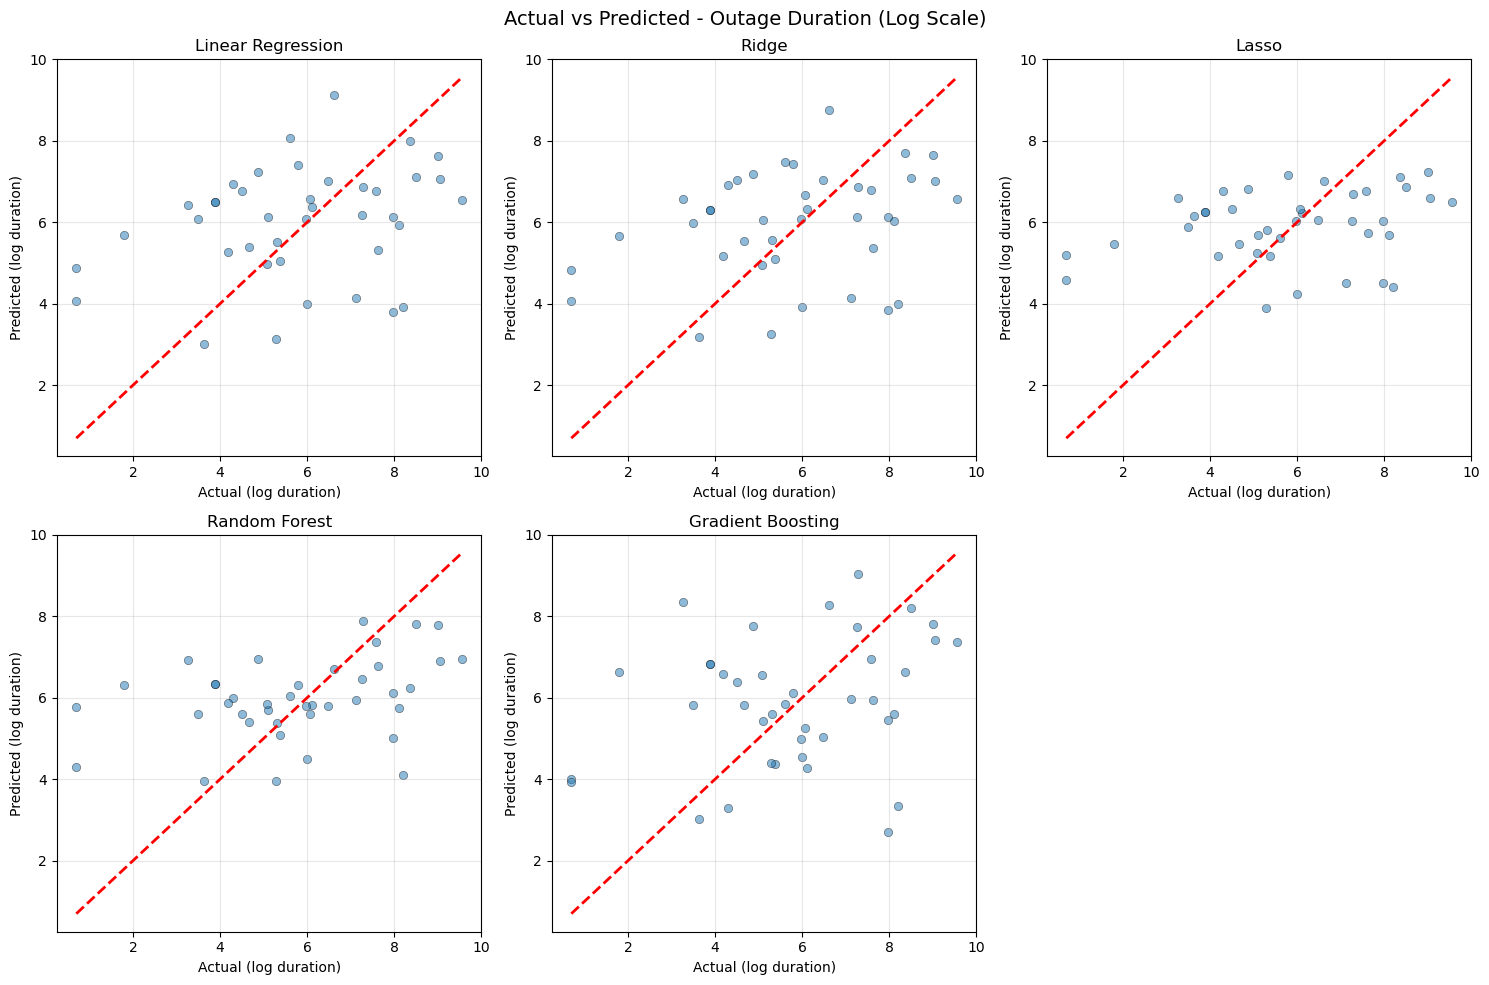

In [17]:
# Actual vs Predicted plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

models_preds = [
    ('Linear Regression', lr_pred),
    ('Ridge', ridge_pred),
    ('Lasso', lasso_pred),
    ('Random Forest', rf_pred),
    ('Gradient Boosting', gb_pred)
]

for idx, (name, pred) in enumerate(models_preds):
    row, col = divmod(idx, 3)
    ax = axes[row, col]
    
    ax.scatter(y_test, pred, alpha=0.5, edgecolors='black', linewidth=0.5)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax.set_xlabel('Actual (log duration)')
    ax.set_ylabel('Predicted (log duration)')
    ax.set_title(f'{name}')
    ax.grid(True, alpha=0.3)

# Hide empty subplot
axes[1, 2].axis('off')

plt.suptitle('Actual vs Predicted - Outage Duration (Log Scale)', fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUTS_PATH + 'figures/actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()

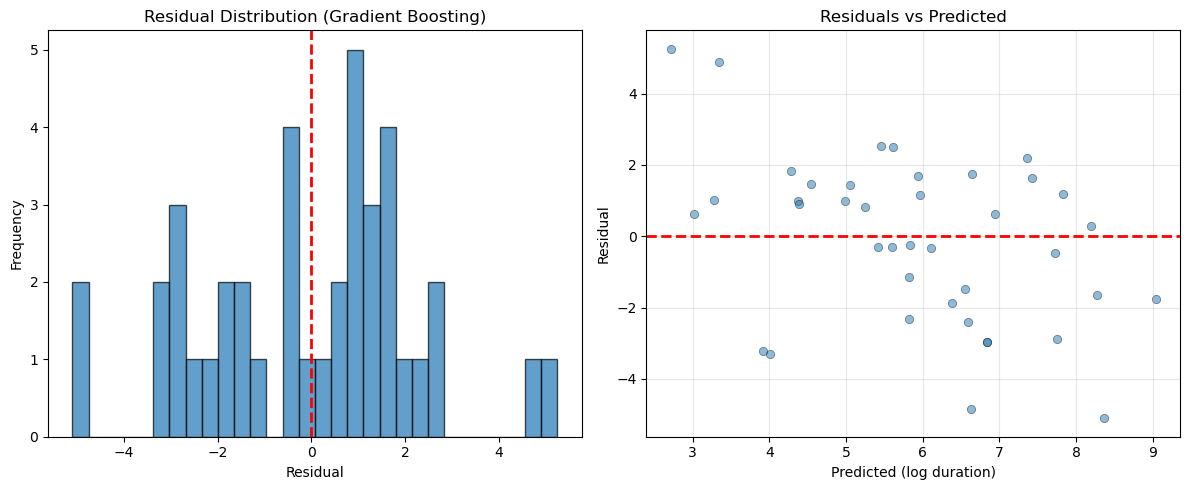

Residual statistics:
  Mean: -0.0965
  Std: 2.3416
  Skewness: -0.0853


In [18]:
# Residual analysis for best model (Gradient Boosting)
residuals = y_test - gb_pred

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Residual distribution
axes[0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', lw=2)
axes[0].set_xlabel('Residual')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Residual Distribution (Gradient Boosting)')

# Residuals vs Predicted
axes[1].scatter(gb_pred, residuals, alpha=0.5, edgecolors='black', linewidth=0.5)
axes[1].axhline(y=0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted (log duration)')
axes[1].set_ylabel('Residual')
axes[1].set_title('Residuals vs Predicted')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUTS_PATH + 'figures/residual_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Residual statistics:")
print(f"  Mean: {residuals.mean():.4f}")
print(f"  Std: {residuals.std():.4f}")
print(f"  Skewness: {residuals.skew():.4f}")

---
## Additional Regression Tasks

### Predicting Customers Affected

In [19]:
# Prepare data for customers affected prediction
X_cust, y_cust = prepare_regression_data(df, 'CUSTOMERS.AFFECTED', all_features, categorical_features, log_transform=True)

X_train_cust, X_test_cust, y_train_cust, y_test_cust = train_test_split(
    X_cust, y_cust, test_size=0.2, random_state=42
)

print(f"Customers Affected Prediction")
print(f"Training samples: {len(X_train_cust)}")
print(f"Test samples: {len(X_test_cust)}")

# Train Gradient Boosting (best performing model)
gb_cust = GradientBoostingRegressor(
    n_estimators=100, max_depth=5, learning_rate=0.1,
    min_samples_split=5, random_state=42
)

gb_cust_metrics, gb_cust_pred, gb_cust_trained = evaluate_regressor(
    gb_cust, X_train_cust, X_test_cust, y_train_cust, y_test_cust, 'GB (Customers)'
)

print(f"\nGradient Boosting Performance for Customers Affected:")
for metric, value in gb_cust_metrics.items():
    if metric != 'Model':
        print(f"  {metric}: {value:.4f}")

Customers Affected Prediction
Training samples: 89
Test samples: 23

Gradient Boosting Performance for Customers Affected:
  MAE (log): 1.7632
  RMSE (log): 2.3098
  R2: -1.4331
  MAE (original): 292793.5304
  RMSE (original): 586338.7686
  CV R2 (mean): -0.0260
  CV R2 (std): 0.2939


---
## Hyperparameter Tuning

In [20]:
# Hyperparameter tuning for Gradient Boosting
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_samples_split': [2, 5, 10]
}

print("Running GridSearchCV for Gradient Boosting Regressor...")
print("This may take a few minutes...\n")

gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train, y_train)

print(f"\nBest Parameters: {gb_grid.best_params_}")
print(f"Best CV R2 Score: {gb_grid.best_score_:.4f}")

# Evaluate best model on test set
y_pred_best = gb_grid.best_estimator_.predict(X_test)

print(f"\nTest Set Performance (Tuned Gradient Boosting):")
print(f"  R2: {r2_score(y_test, y_pred_best):.4f}")
print(f"  MAE (log): {mean_absolute_error(y_test, y_pred_best):.4f}")
print(f"  RMSE (log): {np.sqrt(mean_squared_error(y_test, y_pred_best)):.4f}")

Running GridSearchCV for Gradient Boosting Regressor...
This may take a few minutes...

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50}
Best CV R2 Score: 0.0687

Test Set Performance (Tuned Gradient Boosting):
  R2: 0.0934
  MAE (log): 1.5540
  RMSE (log): 2.0527


In [21]:
# Save best model and results
import joblib

# Save the tuned Gradient Boosting model
joblib.dump(gb_grid.best_estimator_, OUTPUTS_PATH + 'models/gradient_boosting_duration.joblib')
print("Saved tuned Gradient Boosting model to outputs/models/gradient_boosting_duration.joblib")

# Save model comparison results
all_metrics.to_csv(OUTPUTS_PATH + 'regression_results.csv', index=False)
print("Saved regression results to outputs/regression_results.csv")

# Save feature importance
feature_importance.to_csv(OUTPUTS_PATH + 'feature_importance_regression.csv', index=False)
print("Saved feature importance to outputs/feature_importance_regression.csv")

print("\nRegression analysis complete!")

Saved tuned Gradient Boosting model to outputs/models/gradient_boosting_duration.joblib
Saved regression results to outputs/regression_results.csv
Saved feature importance to outputs/feature_importance_regression.csv

Regression analysis complete!
